In [25]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from shapely.geometry import Polygon, Point, LineString
import time

In [26]:
# Check if CUDA (GPU support) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

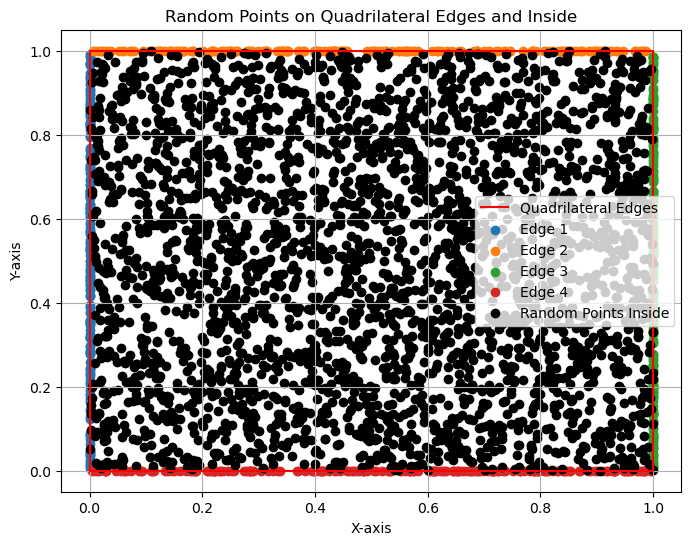

In [27]:
# Define the four corner points of the quadrilateral
points = [(0, 0), (0, 1), (1, 1), (1, 0)]

# Create a Shapely polygon from the points
polygon = Polygon(points)

# Initialize lists to store random points on each edge
bound_pts = [[] for _ in range(len(points))]

# Generate random points on each line segment of the polygon (edges)
num_points_per_edge = 200 # Number of random points to generate on each edge

for i in range(len(points)):
    p1 = points[i]
    p2 = points[(i + 1) % len(points)]  # Wrap around to the first point after the last one

    line = LineString([p1, p2])
    length = line.length

    for _ in range(num_points_per_edge):
        # Generate a random distance along the line segment
        random_distance = np.random.uniform(0, length)
        random_point = line.interpolate(random_distance)
        bound_pts[i].append([random_point.x, random_point.y])

# Generate random points inside the polygon using a bounding box
num_points_inside = 3000  # Number of random points inside the polygon
min_x, min_y, max_x, max_y = polygon.bounds
coloc_pts = []

while len(coloc_pts) < num_points_inside:
    x = np.random.uniform(min_x, max_x)
    y = np.random.uniform(min_y, max_y)
    point = Point(x, y)
    if polygon.contains(point):
        coloc_pts.append([x, y])

# Convert the lists of random points on each edge and inside to NumPy arrays
bound_pts = [np.array(edge_points) for edge_points in bound_pts]
coloc_pts = np.array(coloc_pts)

############################################# Plotting the points and lines #####################################################

plt.figure(figsize=(8, 6))

# Plotting lines connecting the corner points of the quadrilateral
edges = np.array(points + [points[0]])
plt.plot(edges[:, 0], edges[:, 1], 'r-', label='Quadrilateral Edges')

# Plotting random points on each edge separately
for i, edge_points in enumerate(bound_pts):
    edge_points = np.array(edge_points)
    plt.scatter(edge_points[:, 0], edge_points[:, 1], label=f'Edge {i+1}')

# Plotting random points inside the quadrilateral
plt.scatter(coloc_pts[:, 0], coloc_pts[:, 1], color='black', label='Random Points Inside')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Random Points on Quadrilateral Edges and Inside')
plt.legend()
plt.grid(True)
plt.show()

#coloc_pts
#bound_pts


In [28]:
T_l = 700
T_r = 350
T_u = 350
T_b = 350
k = 238
q=1000000.00

In [29]:
coloc_pts = torch.from_numpy(coloc_pts.astype(np.float32)).to(device)

In [30]:
# Convert NumPy array to float32 and then to a PyTorch tensor
bound_pts = [torch.tensor(arr, dtype=torch.float32) for arr in bound_pts]


In [31]:
data_l = bound_pts[0]
data_u = bound_pts[1]
data_r = bound_pts[2]
data_b = bound_pts[3]

# Move tensors to CUDA if available
data_l = data_l.to('cuda')
data_u = data_u.to('cuda')
data_r = data_r.to('cuda')
data_b = data_b.to('cuda')

In [32]:
class PINN2D(nn.Module):
    def __init__(self):
        super(PINN2D, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 31),  # 2 input neurons for (x, y)
            nn.Tanh(),

            nn.Linear(31, 63),
            nn.Tanh(),
            

            nn.Linear(63, 1)
        )

    def forward(self, xy):
        return self.layers(xy)


In [33]:
def pde_loss_2d(model_2d, coloc_pts):
    coloc_pts.requires_grad = True
    T = model_2d(coloc_pts)

    # Compute the second derivatives
    T_x = torch.autograd.grad(T, coloc_pts, torch.ones_like(T), create_graph=True, retain_graph=True)[0][:, 0]
    T_xx = torch.autograd.grad(T_x, coloc_pts, torch.ones_like(T_x), create_graph=True)[0][:, 0]

    T_y = torch.autograd.grad(T, coloc_pts, torch.ones_like(T), create_graph=True, retain_graph=True)[0][:, 1]
    T_yy = torch.autograd.grad(T_y, coloc_pts, torch.ones_like(T_y), create_graph=True)[0][:, 1]

    # Calculate the PDE loss term using your specific PDE equation
    pde_term = (T_xx + T_yy)+(q/k)   # Modify this according to your specific PDE

    # Compute the loss
    loss = torch.mean(torch.square(pde_term))

    return loss



# Proceed with your loss calculations using these boundary values
def left_boundary_loss(model):

    left_boundary_loss = torch.mean(torch.square(T_l - model(data_l)))
    return left_boundary_loss

def upper_boundary_loss(model):

    upper_boundary_loss = torch.mean(torch.square(T_u - model(data_u)))
    return upper_boundary_loss

def right_boundary_loss(model):

    right_boundary_loss = torch.mean(torch.square(T_r - model(data_r)))
    return right_boundary_loss

def bottom_boundary_loss(model):

    bottom_boundary_loss = torch.mean(torch.square(T_b - model(data_b)))
    return bottom_boundary_loss



In [34]:
from torch.optim.lr_scheduler import StepLR

model_2d = PINN2D().to(device)
optimizer_2d = torch.optim.Adam(model_2d.parameters(), lr=0.001)
# Define the scheduler
scheduler = StepLR(optimizer_2d, step_size=50000, gamma=0.95)  # You can adjust step_size and gamma values

In [35]:
s = time.time()
# Training loop
epochs = 50001 # You can adjust the number of epochs
# Forward pass
loss_storage = torch.zeros((1,5),device = device)
test = 0
wp = torch.tensor(1.0, requires_grad=False, device=device)
wl = torch.tensor(1.0, requires_grad=False, device=device)
wr = torch.tensor(1.0, requires_grad=False, device=device)
wu = torch.tensor(1.0, requires_grad=False, device=device)
wb = torch.tensor(1.0, requires_grad=False, device=device)
sf = torch.tensor(0.2,requires_grad=False,device= device)

epoch_list = []
total_loss_list = []
pde_loss_list = []
l_loss_list = []
r_loss_list = []
u_loss_list = []
b_loss_list = []
pde_w_list = []
l_w_list = []
r_w_list = []
u_w_list = []
b_w_list = []



In [36]:
for epoch in range(epochs):


    # Forward pass
    T = model_2d(coloc_pts)
    
    # Compute losses
    p_l = pde_loss_2d(model_2d, coloc_pts)
    l_l = left_boundary_loss(model_2d)
    r_l = right_boundary_loss(model_2d)
    b_l = bottom_boundary_loss(model_2d)
    u_l = upper_boundary_loss(model_2d)
    

    if (epoch > 0)and(epoch%1000 == 0): 

        dLp = (abs((p_l - loss_storage[0,0]))/p_l).clone().detach().requires_grad_(False)
        dLl = (abs((l_l - loss_storage[0,1]))/p_l).clone().detach().requires_grad_(False)
        dLr = (abs((r_l - loss_storage[0,2]))/p_l).clone().detach().requires_grad_(False)
        dLb = (abs((b_l - loss_storage[0,3]))/p_l).clone().detach().requires_grad_(False)
        dLu = (abs((u_l - loss_storage[0,4]))/p_l).clone().detach().requires_grad_(False)
      
        sumdL = torch.sqrt(dLp**2 + dLl**2 + dLr**2 + dLb**2 + dLu**2)
        if dLp>10e-8: 
            wp = wp*sf + (1-sf)*sumdL/dLp
        if dLl>10e-8: 
            wl = wl*sf + (1-sf)*sumdL/dLl
        if dLr>10e-8: 
            wr = wr*sf + (1-sf)*sumdL/dLr
        if dLb>10e-8: 
            wb = wb*sf + (1-sf)*sumdL/dLb
        if dLu>10e-8: 
            wu = wu*sf + (1-sf)*sumdL/dLu
        loss_storage[0,0] = 0
        loss_storage[0,1] = 0
        loss_storage[0,2] = 0
        loss_storage[0,3] = 0

    sum_wts = wp + wl + wr + wb + wu
    total_loss =    (wp*p_l + wl*l_l +  wr*r_l + wb*b_l + wu*u_l)/sum_wts


    if epoch%1000==0:
        epoch_list.append(epoch)
        total_loss_list.append(total_loss.item())
        pde_loss_list.append(p_l.item())
        l_loss_list.append(l_l.item())
        r_loss_list.append(r_l.item())
        u_loss_list.append(u_l.item())
        b_loss_list.append(b_l.item())
        pde_w_list.append(wp.item())
        l_w_list.append(wl.item())
        r_w_list.append(wr.item())
        u_w_list.append(wu.item())
        b_w_list.append(wb.item())


    loss_storage[0,0] = p_l
    loss_storage[0,1] = l_l
    loss_storage[0,2] = r_l
    loss_storage[0,3] = b_l
    loss_storage[0,4] = u_l

    optimizer_2d.zero_grad()
    total_loss.backward()
    optimizer_2d.step()


    # Learning rate scheduling
    scheduler.step()

    
    # Print the loss after every few epochs
    if epoch % 1000 == 0:
        print(f'Epoch: {epoch}, Total Loss: {total_loss.item():.4e}, PDE Loss[{wp}]: {p_l.item():.4e}, Left Loss[{wl}]: {l_l.item():.4e}, Right Loss[{wr}]: {r_l.item():.4e}, Bottom Loss[{wb}]: {b_l.item():.4e}, Upper Loss[{wu}]: {u_l.item():.4e}')
        #print(p,u,b)

e = time.time()

Epoch: 0, Total Loss: 1.8511e+07, PDE Loss[1.0]: 1.7654e+07, Left Loss[1.0]: 4.8982e+05, Right Loss[1.0]: 1.2250e+05, Bottom Loss[1.0]: 1.2254e+05, Upper Loss[1.0]: 1.2237e+05
Epoch: 1000, Total Loss: 1.1227e+08, PDE Loss[1.0177364349365234]: 1.0613e+07, Left Loss[87.71305084228516]: 4.7489e+05, Right Loss[149.93081665039062]: 7.4878e+04, Bottom Loss[354.5738525390625]: 1.0223e+05, Upper Loss[161.88746643066406]: 7.6238e+04
Epoch: 2000, Total Loss: 3.0272e+07, PDE Loss[1.2117441892623901]: 1.4517e+07, Left Loss[25.144302368164062]: 2.7008e+05, Right Loss[53.755924224853516]: 2.9065e+04, Bottom Loss[94.62435913085938]: 2.8512e+04, Upper Loss[55.99951171875]: 2.9103e+04
Epoch: 3000, Total Loss: 2.4378e+07, PDE Loss[1.1147552728652954]: 1.0598e+07, Left Loss[23.940380096435547]: 2.9660e+05, Right Loss[70.4835433959961]: 2.1426e+04, Bottom Loss[79.04004669189453]: 3.0901e+04, Upper Loss[68.37081909179688]: 2.2081e+04
Epoch: 4000, Total Loss: 2.2047e+07, PDE Loss[1.0811927318572998]: 9.6153

In [37]:
print(f'Epoch: {epoch}, Total Loss: {total_loss.item()}, PDE Loss: {p_l.item()}, Left Loss: {l_l.item()}, Right Loss: {r_l.item()}, Bottom Loss: {b_l.item()}, Upper Loss: {u_l.item()}')


Epoch: 50000, Total Loss: 211385.09375, PDE Loss: 68473.6875, Left Loss: 516.0429077148438, Right Loss: 0.2424442172050476, Bottom Loss: 0.024658741429448128, Upper Loss: 0.37069374322891235


In [38]:
print((e-s)/60)

3.4284418702125548


In [39]:
Z=T.cpu().detach().numpy()
X = coloc_pts[:,0].cpu().detach().numpy()
Y = coloc_pts[:,1].cpu().detach().numpy()
Z = Z.reshape(-1,)

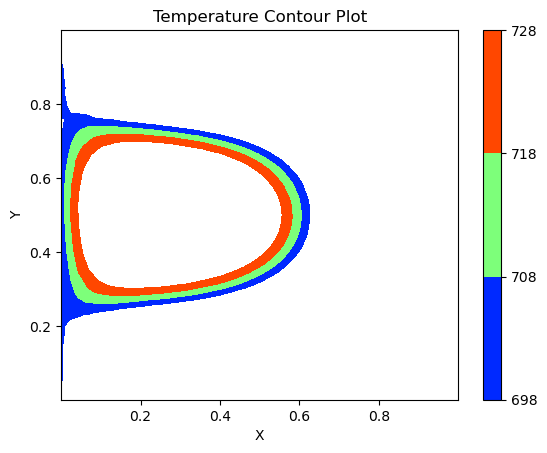

In [53]:
from matplotlib.tri import Triangulation

# Create a Triangulation object
triang = Triangulation(X, Y)
# Define the minimum, maximum, and step size for contour levels
min_val = 698
max_val = 720
step = 10 # Specify the step size for contour levels

# Generate the contour levels using numpy
levels = np.arange(min_val, max_val + step, step)

# Plot the temperature contour with specified levels
plt.tricontourf(triang, Z,levels = levels, cmap='jet')
plt.colorbar()  # Add a color bar indicating the temperature values
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Temperature Contour Plot')
plt.show()

In [41]:
Z

array([368.425  , 525.3146 , 698.9478 , ..., 370.58014, 631.26086,
       374.36908], dtype=float32)

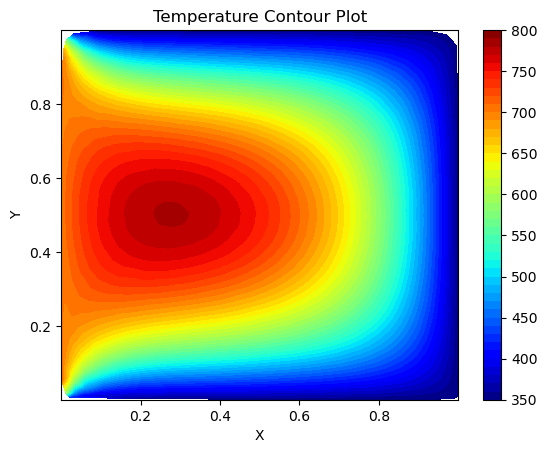

In [42]:
from matplotlib.tri import Triangulation

# Create a Triangulation object
triang = Triangulation(X, Y)
# Define the minimum, maximum, and step size for contour levels
min_val = 350
max_val = 800
step = 10  # Specify the step size for contour levels

# Generate the contour levels using numpy
levels = np.arange(min_val, max_val + step, step)

# Plot the temperature contour with specified levels
plt.tricontourf(triang, Z,levels = levels, cmap='jet')
plt.colorbar()  # Add a color bar indicating the temperature values
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Temperature Contour Plot')
plt.show()

In [43]:
print(Z.min(), Z.max())

349.13934 781.45715


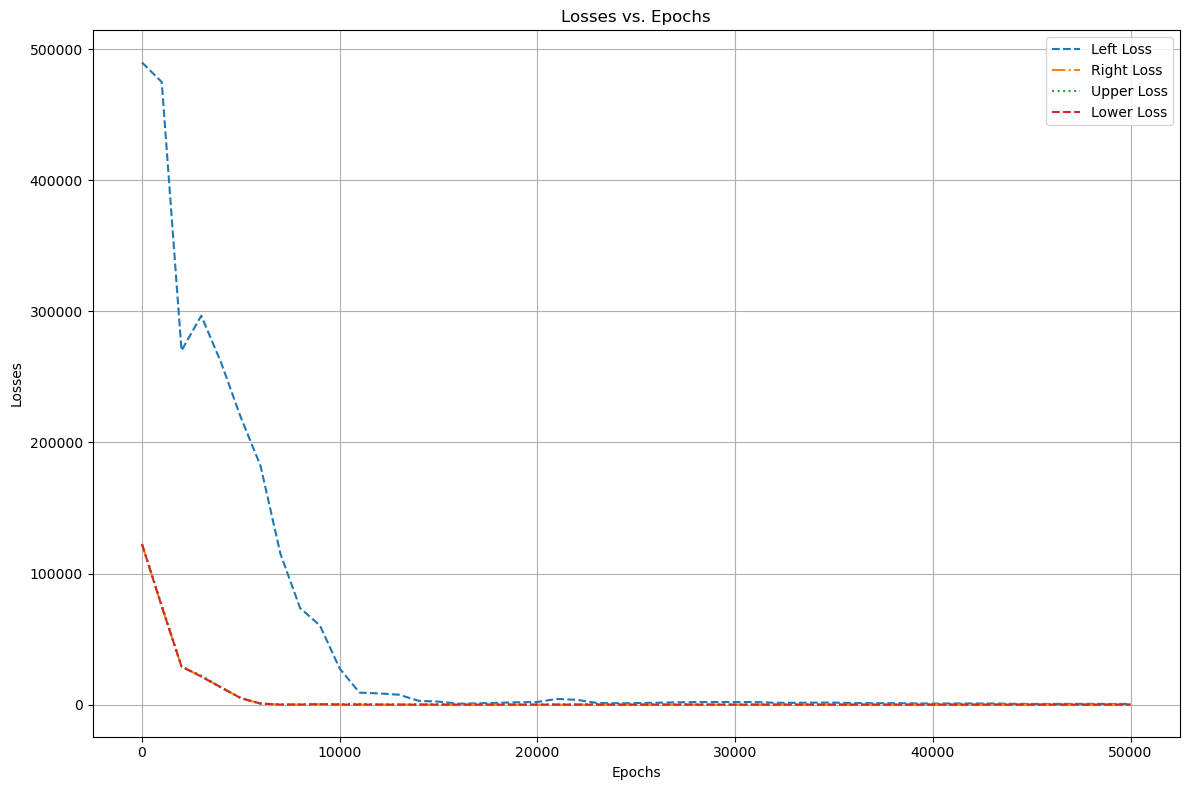

In [44]:
epoch_arr = np.array(epoch_list)
total_loss_arr = np.array(total_loss_list)
pde_loss_arr = np.array(pde_loss_list)
l_loss_arr = np.array(l_loss_list)
r_loss_arr = np.array(r_loss_list)
u_loss_arr = np.array(u_loss_list)
b_loss_arr = np.array(b_loss_list)
pde_w_arr = np.array(pde_w_list)
l_w_arr = np.array(l_w_list)
r_w_arr = np.array(r_w_list)
u_w_arr = np.array(u_w_list)
b_w_arr = np.array(b_w_list)


plt.figure(figsize=(12,8))
#plt.plot(epoch_list,total_loss_arr,label = 'Total Loss',linewidth = 2)
#plt.plot(epoch_list,pde_loss_arr,label = 'PDE Loss',linestyle = ':')
plt.plot(epoch_list,l_loss_arr,label = 'Left Loss',linestyle = '--')
plt.plot(epoch_list,r_loss_arr,label = 'Right Loss',linestyle = '-.')
plt.plot(epoch_list,u_loss_arr,label = 'Upper Loss',linestyle = ':')
plt.plot(epoch_list,r_loss_arr,label = 'Lower Loss',linestyle = '--')
plt.title("Losses vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

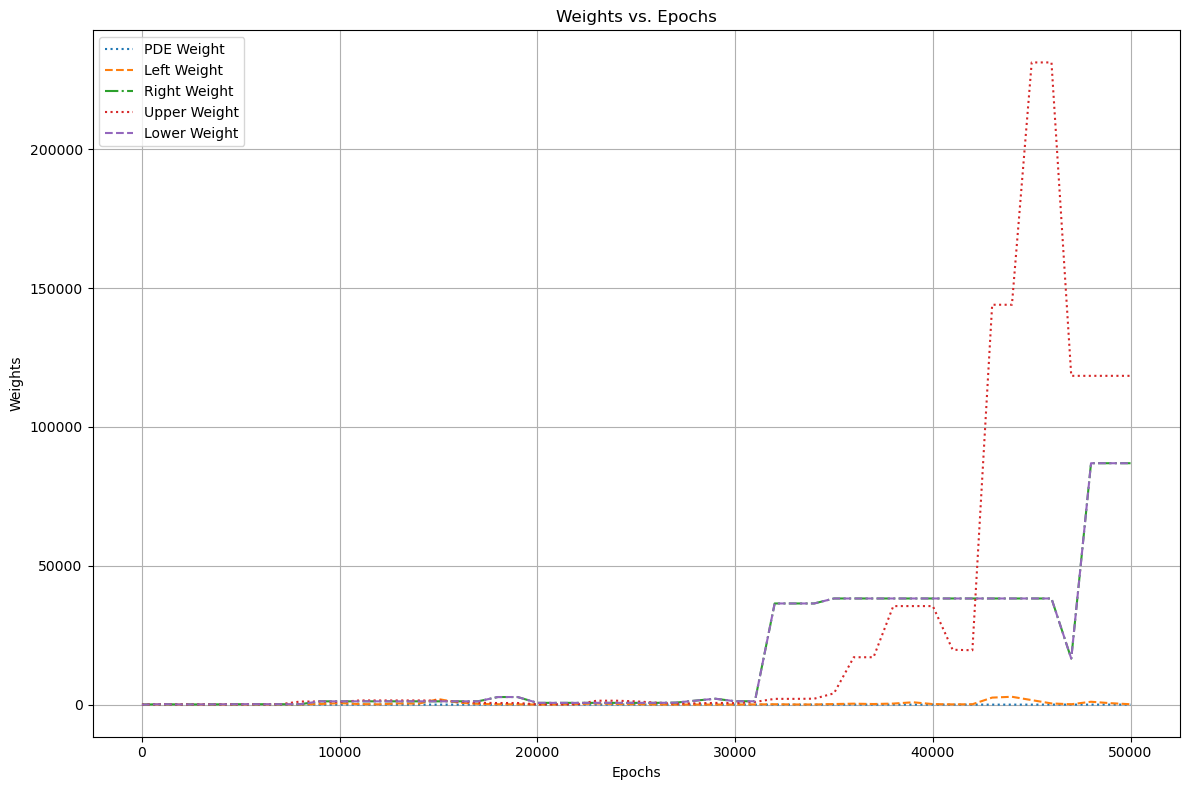

In [45]:
plt.figure(figsize=(12,8))
#plt.plot(epoch_list,total_loss_arr,label = 'Total Loss',linewidth = 2)
plt.plot(epoch_list,pde_w_arr,label = 'PDE Weight',linestyle = ':')
plt.plot(epoch_list,l_w_arr,label = 'Left Weight',linestyle = '--')
plt.plot(epoch_list,r_w_arr,label = 'Right Weight',linestyle = '-.')
plt.plot(epoch_list,u_w_arr,label = 'Upper Weight',linestyle = ':')
plt.plot(epoch_list,r_w_arr,label = 'Lower Weight',linestyle = '--')
plt.title("Weights vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Weights")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()